In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import copy
import itertools
from utils_graphs import create_graph, plot_graph, get_colors, fig_graph_degrees
import utils_PLS as upls
import matplotlib.colors as cm
from matplotlib.lines import Line2D

In [2]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [19]:
batch = 'Black_wf_WholeBrain'
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_Black_wf_WholeBrain_unfiltered.npy', 
                                   allow_pickle=True).item()
subjects = list(dict_results_across_mice.keys())
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

In [47]:
corr_threshold = 0.85
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
macroareas_to_exclude = ['Pons', 'Medulla', 'Cerebellar cortex', 'Cerebellar nuclei']

In [21]:
df_levels = upls.create_df_levels(volumes, level=8)

# Analysis on number of cells

In [22]:
significant_areas = ace.select_significant_areas(dictionary=dict_results_across_mice, 
                                             experimental_groups=experimental_groups, 
                                             batch=batch,
                                             test='mannwhitneyu', 
                                             threshold_test=0.05,
                                             threshold_pls=2.56,
                                             value_test='density', 
                                             value_pls='relative_density')
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [24]:
G_control = create_graph(corr_matrix_control_ncells, volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')
G_fam = create_graph(corr_matrix_fam_ncells,  volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')
G_unfam = create_graph(corr_matrix_unfam_ncells,  volumes=volumes, 
                         significant_areas=significant_areas, 
                         corr_threshold=corr_threshold, correlations='one')

## Graphs of positive correlations

(<Figure size 1656x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a98954128>)

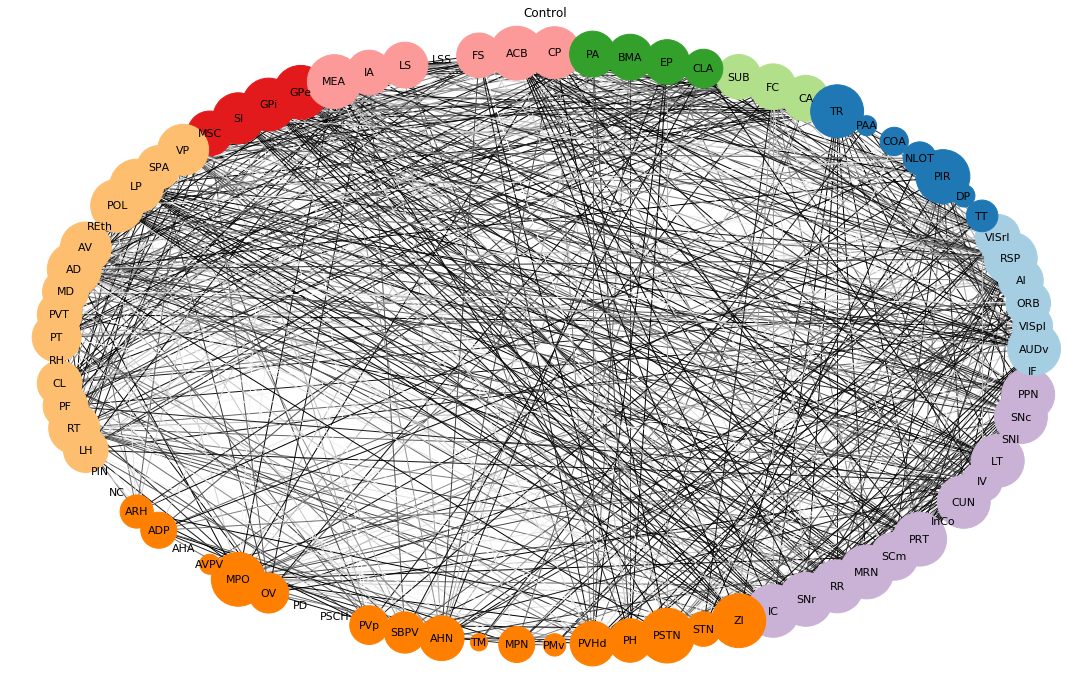

In [28]:
fig_graph_degrees(G=G_control, title='Control', volumes=volumes, figsize=(23,12), 
                  show_degrees=False, show_colorbar=False, show_legend=False, fontsize=11)

(<Figure size 1656x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a986660f0>)

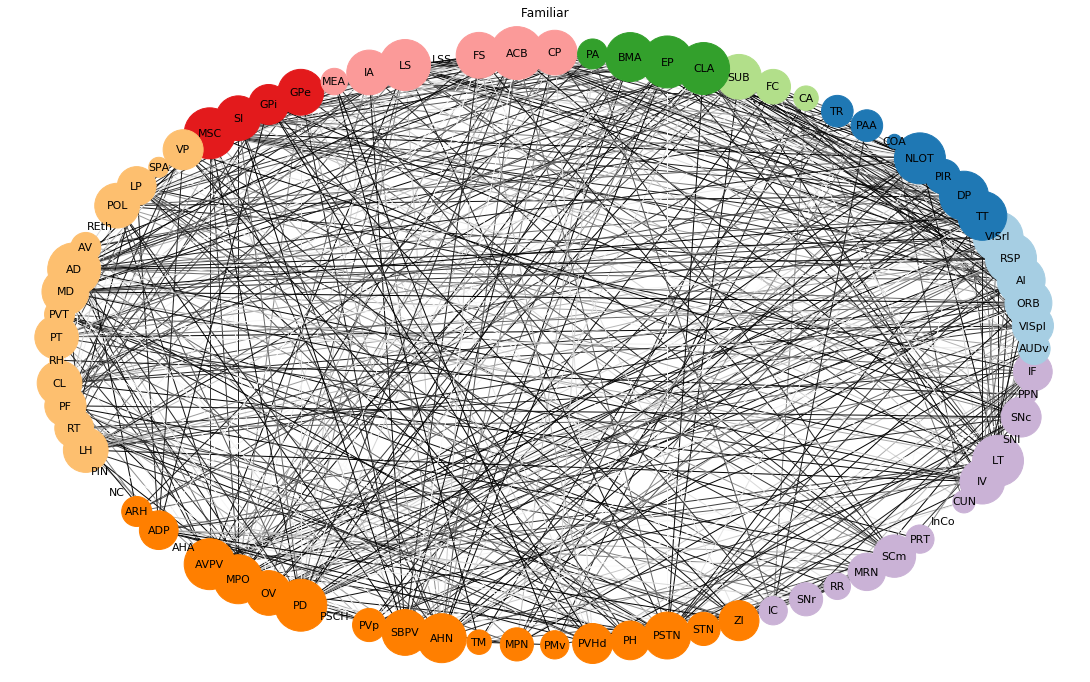

In [29]:
fig_graph_degrees(G=G_fam, title='Familiar', volumes=volumes, figsize=(23,12), 
                  show_degrees=False, show_colorbar=False, show_legend=False, fontsize=11)

(<Figure size 1656x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6a96af7860>)

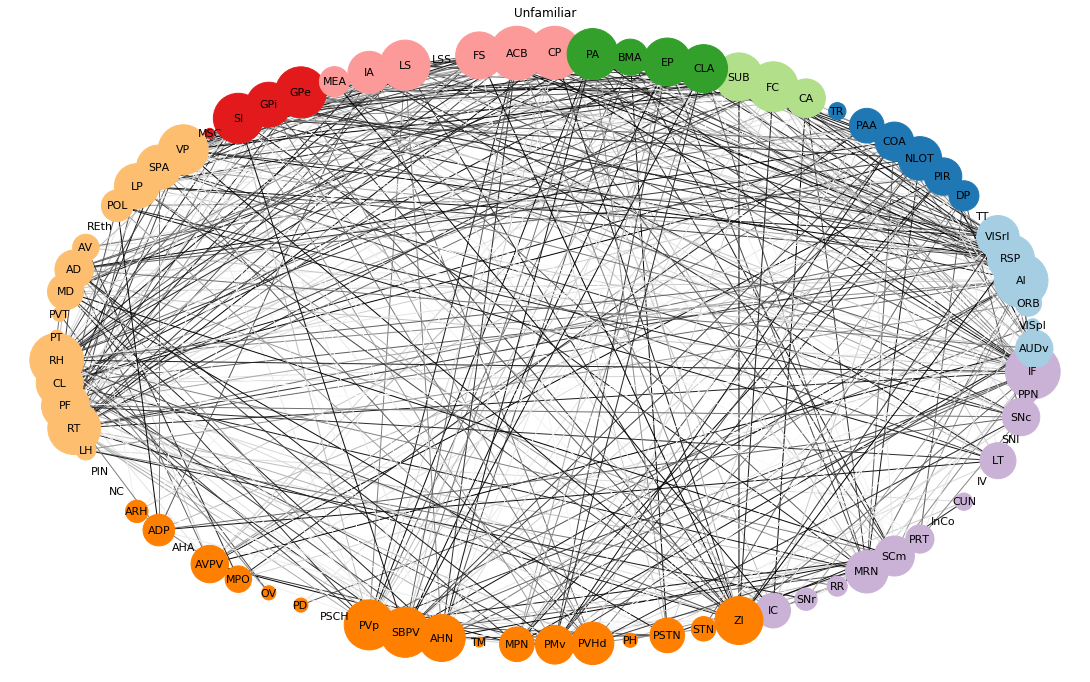

In [30]:
fig_graph_degrees(G=G_unfam, title='Unfamiliar', volumes=volumes, figsize=(23,12), 
                  show_degrees=False, show_colorbar=False, show_legend=False, fontsize=11)

## Using Spring layout

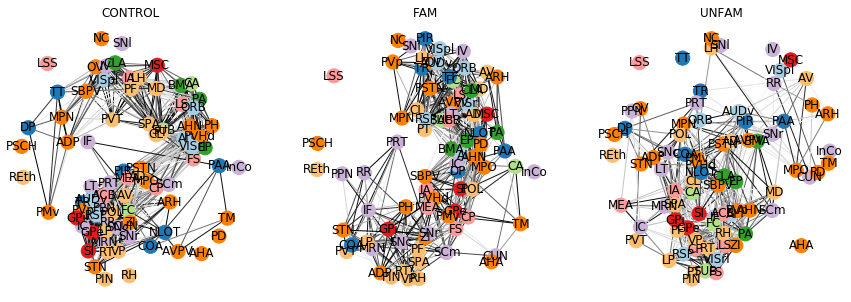

In [34]:
show_colorbar=True
show_legend=True
Gs = [G_control, G_fam, G_unfam]
titles=['CONTROL', 'FAM', 'UNFAM']
# create tables
allen_order = list(volumes[volumes['st_level']==8]['acronym'])
df_levels = upls.create_df_levels(volumes, level=8)

# create figure
fig = plt.figure(figsize=(15, 5))

edge_cmap = plt.cm.get_cmap('Greys')

# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(1, 3)
# plot graph
for i, G in enumerate(Gs):
    ax = fig.add_subplot(axgrid[i])

    order=allen_order

    # Plot the network:
    # pos = nx.spring_layout(sorted(list(G.nodes()),
    #   key = order.index))
    pos = nx.spring_layout(G, k=1, seed=42)
    list_colors = get_colors(G, df_levels, order, volumes=volumes,
                            macroareas_to_exclude=macroareas_to_exclude)[0]
    nx.draw(G, with_labels=True, node_color=list_colors, 
            node_size=200,font_size=12, pos=pos, ax=ax, edge_cmap=edge_cmap, width=1,
            edge_color=[G[u][v]['weight'] for u, v in G.edges])

    # relabel graphs
    ax.set_title(titles[i])


## Histogram degrees

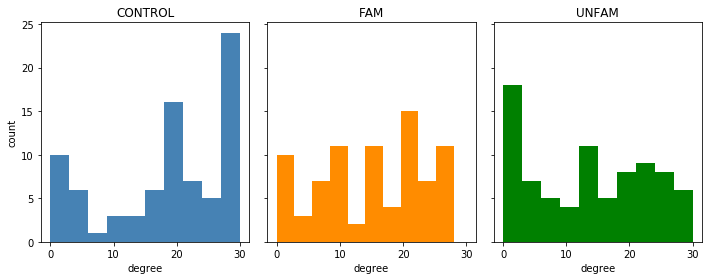

In [35]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
axes[0].set_title('CONTROL')
axes[0].hist(list(dict(G_control.degree).values()),
            color='steelblue')
axes[1].set_title('FAM')
axes[1].hist(list(dict(G_fam.degree).values()),
            color='darkorange')
axes[2].set_title('UNFAM')
axes[2].hist(list(dict(G_unfam.degree).values()),
            color='green')
for i in range(3):
    axes[i].set_xlabel('degree')
axes[0].set_ylabel('count')
plt.tight_layout()

Text(0, 0.5, 'Degree')

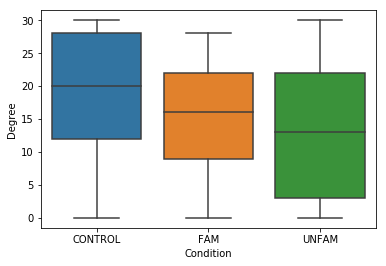

In [36]:
df_boxplot = pd.DataFrame({'CONTROL':list(dict(G_control.degree).values()), 
                           'FAM': list(dict(G_fam.degree).values()), 
                           'UNFAM':list(dict(G_unfam.degree).values())})
fig, ax = plt.subplots(1,1)
sns.boxplot(data=df_boxplot, ax=ax)
ax.set_xlabel('Condition')
ax.set_ylabel('Degree')

## Histogram weights

Text(0.5, 0.98, 'Correlation distribution of significant areas')

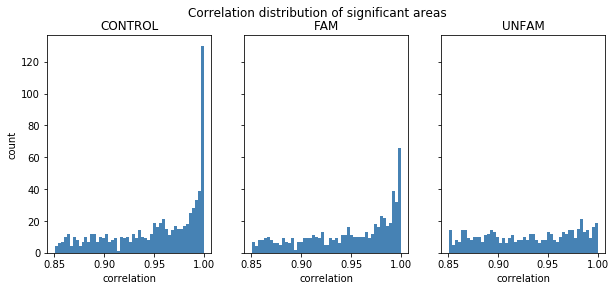

In [38]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
for i, G in enumerate([G_control, G_fam, G_unfam]):
    axes[i].hist([G[u][v]['weight'] for u, v in G.edges],
            color='steelblue', bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlation distribution of significant areas')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation.png')

## Overall correlations

Text(0.5, 0.98, 'Correlations of all areas')

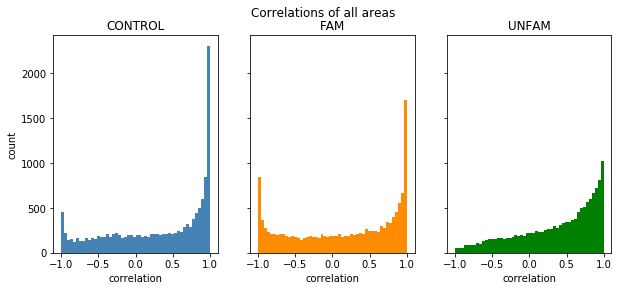

In [39]:
fig, axes = plt.subplots(1,3, figsize=(10,4), sharex=True, sharey=True)
colors = ['steelblue', 'darkorange', 'green']
for i, corr in enumerate([corr_matrix_control_ncells, 
                          corr_matrix_fam_ncells, 
                          corr_matrix_unfam_ncells]):
    axes[i].hist(corr.mask(np.triu(np.ones(corr.shape)).astype(bool)).stack().values,
            color=colors[i], bins=50)
axes[0].set_title('CONTROL')
axes[1].set_title('FAM')
axes[2].set_title('UNFAM')
for i in range(3):
    axes[i].set_xlabel('correlation')
axes[0].set_ylabel('count')
plt.suptitle('Correlations of all areas')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all.svg')
# plt.savefig('/home/stella/Documents/Torino/projects/SexualImprinting/figures/hist_correlation_all.png')

## Look at betweenness for graphs

Text(0, 0.5, 'Average Betweenness Centrality')

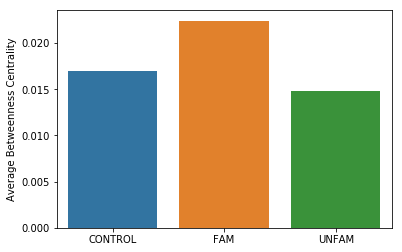

In [41]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
betweenness_centrality = [nx.betweenness_centrality(G) for G in graphs]
df_betweenness_centrality = pd.DataFrame({'CONTROL': [np.mean(list(betweenness_centrality[0].values()))], 
                                'FAM': [np.mean(list(betweenness_centrality[1].values()))],
                                'UNFAM': [np.mean(list(betweenness_centrality[2].values()))]})
sns.barplot(data=df_betweenness_centrality, ax=axes)
axes.set_ylabel('Average Betweenness Centrality')

In [60]:
def plot_betweenness(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(15, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes,
                                              macroareas_to_exclude=macroareas_to_exclude)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        betweenness = [nx.betweenness_centrality(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= betweenness)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes,
                                              macroareas_to_exclude=macroareas_to_exclude)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Betweenness")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

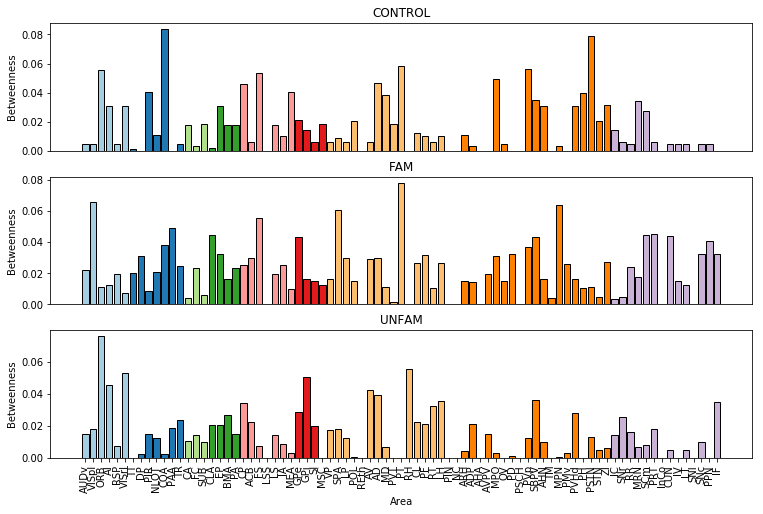

In [61]:
plot_betweenness(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

## Efficiency

The efficiency of a pair of nodes in a graph is the multiplicative inverse of the shortest path distance between the nodes. The average global efficiency of a graph is the average efficiency of all pairs of nodes

Text(0, 0.5, 'Global efficiency')

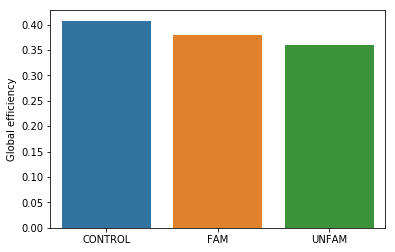

In [52]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
efficiencies = [nx.global_efficiency(G) for G in graphs]
df_efficiencies = pd.DataFrame({'CONTROL': [efficiencies[0]], 
                                'FAM': [efficiencies[1]],
                                'UNFAM': [efficiencies[2]]})
sns.barplot(data=df_efficiencies, ax=axes)
axes.set_ylabel('Global efficiency')

## Clustering

For weighted graphs, there are several ways to define clustering [1]. the one used here is defined as the geometric average of the subgraph edge weights [2],

Text(0, 0.5, 'Clustering')

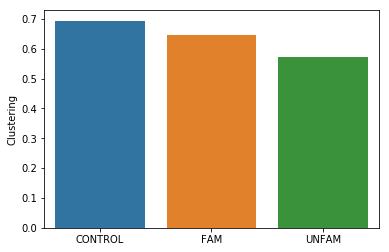

In [53]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
clustering = [nx.clustering(G) for G in graphs]
df_clustering = pd.DataFrame({'CONTROL': [np.mean(list(clustering[0].values()))], 
                                'FAM': [np.mean(list(clustering[1].values()))],
                                'UNFAM': [np.mean(list(clustering[2].values()))]})
sns.barplot(data=df_clustering, ax=axes)
axes.set_ylabel('Clustering')

In [62]:
def plot_clustering(graphs, volumes):
    graphs_titles = ['CONTROL', 'FAM', 'UNFAM']
    # create tables
    allen_order = list(volumes[volumes['st_level']==8]['acronym'])
    df_levels = upls.create_df_levels(volumes, level=8)

    # create figure
    fig, axes = plt.subplots(3,1, figsize=(15, 8))
    plt.subplots_adjust(left=0.25)
    for i, G in enumerate(graphs):
        colors_dict = get_colors(G, df_levels=df_levels, order=allen_order, volumes=volumes,
                                              macroareas_to_exclude=macroareas_to_exclude)[1]
        areas = sorted(list(G.nodes()), key = allen_order.index)
        clustering = [nx.clustering(G)[area] for area in areas]

        # plot degrees
        axes[i].bar(x= areas, 
                height= clustering)

        for idx, color in enumerate(get_colors(G, 
                                               df_levels=df_levels, 
                                               order=allen_order,
                                               sorting=True,
                                               volumes=volumes,
                                              macroareas_to_exclude=macroareas_to_exclude)[0]):
            axes[i].get_children()[idx].set_color(color) 
            axes[i].get_children()[idx].set_edgecolor('black')
        axes[i].set_title(graphs_titles[i])
        axes[i].set_ylabel("Clustering Coefficient")
        axes[i].set_xlabel('')
        if i in [0,1]:
            axes[i].set_xticks([])
    axes[2].set_xlabel("Area")
    axes[2].tick_params(axis='x', labelrotation=90)

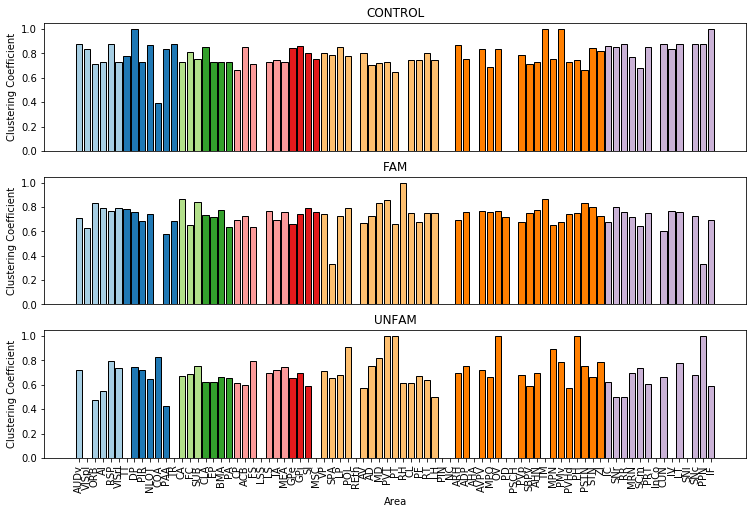

In [63]:
plot_clustering(graphs=[G_control, G_fam, G_unfam], volumes=volumes)

## Rich club coefficient
Returns the rich-club coefficient of the graph G.

For each degree k, the rich-club coefficient is the ratio of the number of actual to the number of potential edges for nodes with degree greater than k

Text(0, 0.5, 'Rich Club Coefficient')

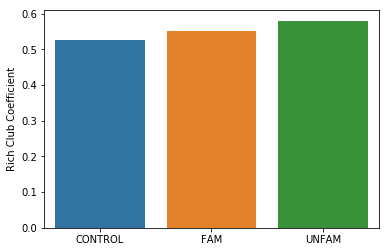

In [64]:
fig, axes = plt.subplots(1,1)
graphs=[G_control, G_fam, G_unfam]
rich_club_coefficient = [nx.rich_club_coefficient(G, normalized=False) for G in graphs]
df_rich_club_coefficient = pd.DataFrame({'CONTROL': [np.mean(list(rich_club_coefficient[0].values()))], 
                                'FAM': [np.mean(list(rich_club_coefficient[1].values()))],
                                'UNFAM': [np.mean(list(rich_club_coefficient[2].values()))]})
sns.barplot(data=df_rich_club_coefficient, ax=axes)
axes.set_ylabel('Rich Club Coefficient')